In [1]:
import GraphDataSets as D
import GraphNN as G
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplhep as hep

from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
from torch_geometric.loader import DataLoader

from iminuit import Minuit, describe
from probfit import Extended, BinnedChi2
from probfit import gaussian, linear, poly2, Chi2Regression
from scipy   import integrate

/lhome/ific/l/lopezneu/ific108/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def gaussNorm(x, mu, sigma, N):
    return (N*np.exp(-0.5 * np.power((x - mu)/(sigma),2 ))/( sigma * np.sqrt( 2 * np.pi)))

def expNorm(x, C, s, xmin, xmax):
    return C * s * np.exp(-x * s) /  (np.exp(-s * xmin) - np.exp(-s * xmax))

def gaussExp_Norm(x, mu, sigma, N, C, s, xmin, xmax) :
    return gaussNorm(x, mu, sigma, N) + expNorm(x, C, s, xmin, xmax)

In [3]:
transform    = True
radius       = 2
model_name   = f'RecoBig_all_10mm_R{radius}'
dataset_name = f'RealData_R{radius}'

In [4]:
DS = getattr(D,dataset_name)
dataset = DS(root='/lhome/ific/f/fkellere/NEXT_Graphs/GNN_datasets')

In [5]:
if transform:
    model_name += '_T'
path  = '/lhome/ific/f/fkellere/NEXT_Graphs/'+model_name+'_best.pth'
model = G.InteractionNetwork(128,dataset=dataset,inputs = dataset.num_node_features, outputs = 2)
model.load_state_dict(torch.load(path,map_location='cpu'))
model.eval()

InteractionNetwork(
  (interactionnetwork): MetaLayer(
    edge_model=EdgeBlock(
    (edge_mlp): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
    node_model=NodeBlock(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=132, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_features=132, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  ),
    global_model=GlobalBlock(
    (global_mlp): Sequential(
     

In [6]:
batch_size = 32

Loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
def IN_analysis(loader):
    t = tqdm(enumerate(loader),total=len(loader))
    y_predict = []
    for i,data in t: 
        try:
            batch_output = model(data.x, data.edge_index, data.edge_attr, data.u, data.batch)
        except:
            batch_output = model(data.x, data.edge_index, data.edge_attr, None, data.batch)
        for j,obj in enumerate(batch_output.detach().cpu().numpy()):
            y_predict.append(batch_output.detach().cpu().numpy()[j][1])
    y_predict = np.array(y_predict)
    y_predict = np.exp(y_predict)/(1+np.exp(y_predict))
        

    return y_predict

In [8]:
y_predict = IN_analysis(Loader)

  0%|          | 0/776 [00:00<?, ?it/s]

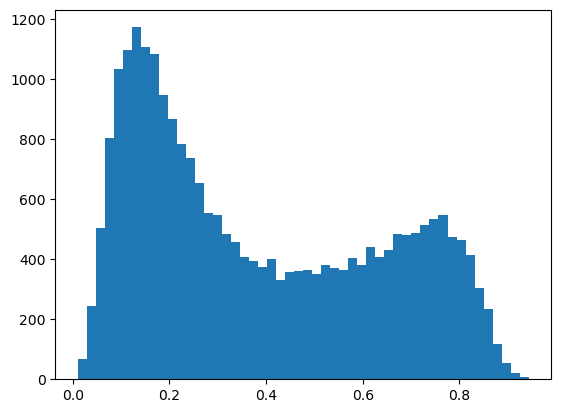

In [9]:
plt.hist(y_predict,50);
#plt.semilogy()

In [10]:
cut = np.median(y_predict)

In [11]:
source      = pd.read_hdf(DS.raw_file_names.fget(DS)[0])
E           = np.array(source.groupby(['dataset_id'])['energy'].sum())
S           = []
B           = []
S = [E[i] for i in range(len(y_predict)) if y_predict[i]>cut]
B = [E[i] for i in range(len(y_predict)) if y_predict[i]<cut]

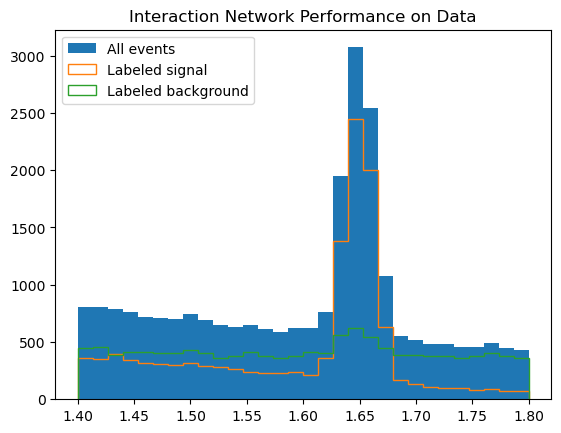

In [12]:
plt.hist(E,30,label='All events')
plt.hist(S,30,histtype='step',label='Labeled signal')
plt.hist(B,30,histtype='step',label='Labeled background');
#plt.semilogy()
plt.title('Interaction Network Performance on Data')
plt.legend();

  0%|          | 0/24831 [00:00<?, ?it/s]

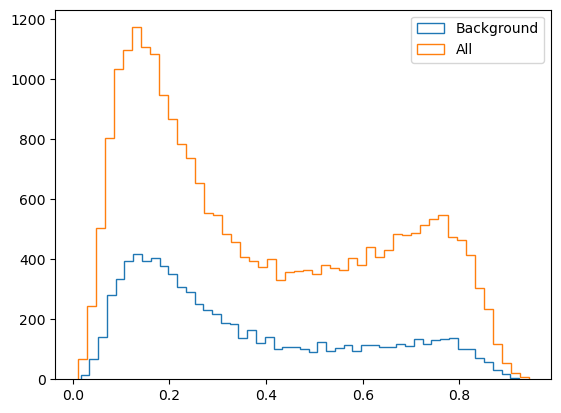

In [13]:
#Background scores (below 1.55 MeV) vs. overall scores
y_pred_B = []
for i in tqdm(range(0,len(y_predict))):
    if E[i]<1.55:
        y_pred_B.append(y_predict[i])
plt.hist(y_pred_B,50,histtype='step',label='Background');
plt.hist(y_predict,50,histtype='step',label='All');
plt.legend()
#plt.semilogy()

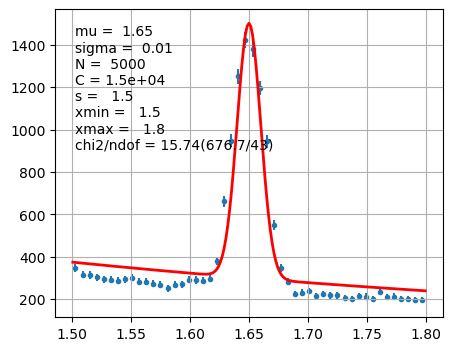

In [14]:
# Create the cost function.
bins_fit   = 50
fit_range  = (1.5, 1.8)
mu         = 1.65
sigma      = 0.01
N          = 5000
C          = 15000
s          = 1.5

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, E, bins = bins_fit , bound=fit_range)
chi2.show(args={'mu':mu, 'sigma':sigma, 'N':N,  'C':C, 's':s , 'xmin':fit_range[0], 'xmax':fit_range[1]})
plt.show()

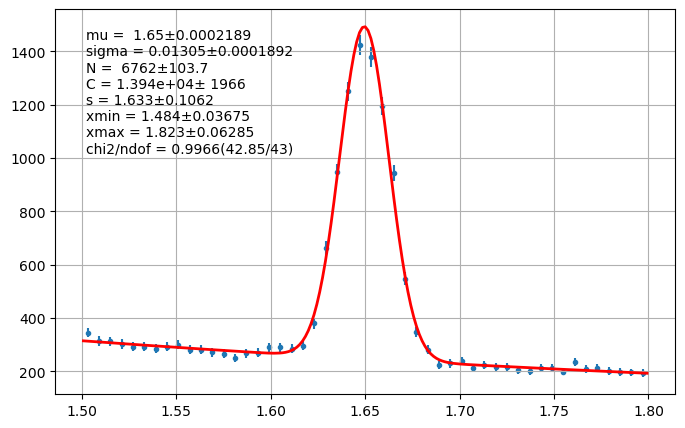

Mean:  1.65         +/- 0.00022 
Sigma: 0.01        +/- 0.00019 
N:     6761.9            +/- 104 
C:     13939.9            +/- 1966 
s:     1.6            +/- 0.11 
chi2:  1.00     


In [15]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=mu, sigma=sigma, N=N,  C=C, s=s, xmin=fit_range[0], xmax=fit_range[1])
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

print(f'Mean:  {mean:.2f}         +/- {mean_u:.5f} ')
print(f'Sigma: {sigma:.2f}        +/- {sigma_u:.5f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')

In [16]:
Nt = integrate.quad(lambda x: gaussExp_Norm(x,minuit.values[0],minuit.values[1],minuit.values[2],minuit.values[3],
                                       minuit.values[4],fit_range[0],fit_range[1]),
                    minuit.values[0]-3*minuit.values[1],minuit.values[0]+3*minuit.values[1])
NS = minuit.values[2]
NB = Nt[0]-minuit.values[2]

In [17]:
ROCx = []
ROCy = []
FOM  = []
for c in np.linspace(0,1,10):
    S    = [E[i] for i in range(len(y_predict)) if y_predict[i]>c]
    try:
        chi2 = BinnedChi2(gaussExp_Norm, S, bins = bins_fit , bound=fit_range)
    except ValueError:
        ROCx.append(1)
        ROCy.append(0)
        FOM. append(0)
        continue
    minuit = Minuit(chi2, mu=mu, sigma=sigma, N=N*len(S)/len(E),  C=C*len(S)/len(E),
                    s=s, xmin=fit_range[0], xmax=fit_range[1])
    minuit.migrad()
    chi2_result = minuit.fval/chi2.ndof
    print(f'chi2: {chi2_result}')
    Nt = integrate.quad(lambda x: gaussExp_Norm(x,minuit.values[0],minuit.values[1],minuit.values[2],
                                               minuit.values[3],minuit.values[4],fit_range[0],fit_range[1]),
                       minuit.values[0]-3*minuit.values[1],minuit.values[0]+3*minuit.values[1])
    minuit.values[2]
    ROCx.append(1-(Nt[0]-minuit.values[2])/NB)
    ROCy.append(minuit.values[2]/NS)
    FOM. append(minuit.values[2]*np.sqrt(NB)/(NS*np.sqrt(Nt[0]-minuit.values[2])))

chi2: 0.9965635426817824
chi2: 1.065536219463955
chi2: 1.357504232577226
chi2: 1.0992240284756156
chi2: 1.0125937437507673
chi2: 1.0233814755215709
chi2: 0.8653815181644458


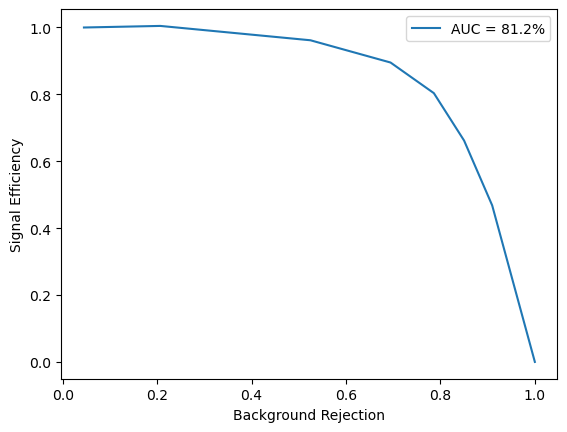

In [18]:
#plt.style.use(hep.style.ROOT)
plt.plot(ROCx,ROCy,label="AUC = {:.1f}%".format(integrate.trapezoid(ROCy,ROCx)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
plt.legend()

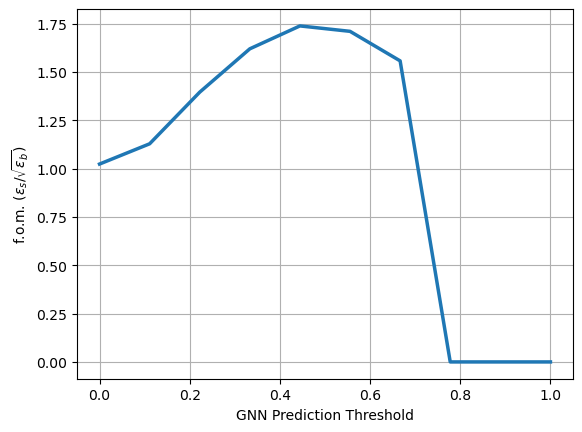

In [19]:
plt.figure()
plt.plot(np.linspace(0,1,10), FOM, lw=2.5)
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.show()

In [20]:
fom  = [x for x in FOM if x!=np.inf]
xmax = np.linspace(0,1,10)[np.argmax(fom)]
print(f'Max FOM: {max(fom).round(2)} at threshold {xmax.round(2)}')

Max FOM: 1.74 at threshold 0.44


In [21]:
#plt.hist(y_predict,50,histtype='step',label='All');
#plt.hist([y_predict[i] for i in range(len(y_predict)) if source.groupby('dataset_id').size()[i]>100],50);

In [22]:
thre_IN = np.linspace(0,1,10)
Figm_IN = FOM
Seff_IN = ROCy
Brej_IN = ROCx
%store thre_IN
%store Figm_IN
%store Seff_IN
%store Brej_IN

Stored 'thre_IN' (ndarray)
Stored 'Figm_IN' (list)
Stored 'Seff_IN' (list)
Stored 'Brej_IN' (list)
